# Predicting Loan Payback

## 1. Данные и задача

Цель данного эссе — разработка модели машинного обучения для предсказания выплаты кредиты среди всех представленных в выборке людей. Модель должна эффективно разделять заемщиков на две категории — выплатил кредит/ не выплатил кредит
Тренировочная и тестовая выборка определены заранее, Предсказание будет проводиться на тестовой

https://drive.google.com/file/d/1ezc2rCe8VmJIAccZJU-0c4Ugu50gvUK4/view?usp=drive_link

In [1]:
# помощник писать код
import jupyter_black

jupyter_black.load()

# импорты основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import (
    classification_report,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)

from catboost import CatBoostClassifier
from catboost import Pool, cv


# для анализа зависимостей между признаками
import phik
from phik.report import plot_correlation_matrix

import warnings


# поможет раскрасить датафрейм
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Скроем лишние предупреждения
warnings.filterwarnings("ignore")
# Настройки Pandas для вывода всех столбцов
pd.set_option("display.max_columns", None)
# улучшение четкости изображения графиков
%config InlineBackend.figure_format = 'retina'

In [3]:
#!gdown "1ezc2rCe8VmJIAccZJU-0c4Ugu50gvUK4" -O data/

In [4]:
#!unzip data/playground-series-s5e11.zip -d data/

In [5]:
train = pd.read_csv("../data/train.csv")
train.head(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [6]:
test = pd.read_csv("../data/test.csv")
test.head(2)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1


## 2. Обработка значений и знакомство с признаками

In [7]:
train.columns

Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'gender', 'marital_status',
       'education_level', 'employment_status', 'loan_purpose',
       'grade_subgrade', 'loan_paid_back'],
      dtype='object')

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


In [9]:
train.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [10]:
categorical_columns = train.select_dtypes(include=["object", "category"]).columns
for cat in categorical_columns:
    print(f" Feature {cat} has {train[cat].nunique()} categories. Values distributed:")
    print(train[cat].value_counts())

 Feature gender has 3 categories. Values distributed:
gender
Female    306175
Male      284091
Other       3728
Name: count, dtype: int64
 Feature marital_status has 4 categories. Values distributed:
marital_status
Single      288843
Married     277239
Divorced     21312
Widowed       6600
Name: count, dtype: int64
 Feature education_level has 5 categories. Values distributed:
education_level
Bachelor's     279606
High School    183592
Master's        93097
Other           26677
PhD             11022
Name: count, dtype: int64
 Feature employment_status has 5 categories. Values distributed:
employment_status
Employed         450645
Unemployed        62485
Self-employed     52480
Retired           16453
Student           11931
Name: count, dtype: int64
 Feature loan_purpose has 8 categories. Values distributed:
loan_purpose
Debt consolidation    324695
Other                  63874
Car                    58108
Home                   44118
Education              36641
Business             

In [11]:
train.duplicated().sum()

0

In [12]:
def count_outliers(df):
    """
    Функция анализирует выбросы в числовых столбцах DataFrame,
    используя метод межквартильного размаха (IQR).
    Возвращает DataFrame с количеством и процентом выбросов.
    """
    numeric_cols = df.select_dtypes(include=["number"]).columns

    features, lower_outliers, upper_outliers = [], [], []

    for col in numeric_cols:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_limit, upper_limit = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        lower_count = (df[col] < lower_limit).sum()
        upper_count = (df[col] > upper_limit).sum()

        if lower_count > 0 or upper_count > 0:
            features.append(col)
            lower_outliers.append(lower_count)
            upper_outliers.append(upper_count)

    if features:
        return pd.DataFrame(
            {
                "variables": features,
                "lower_outliers": lower_outliers,
                "upper_outliers": upper_outliers,
                "lower_outliers%": [
                    round(x / len(df) * 100, 2) for x in lower_outliers
                ],
                "upper_outliers%": [
                    round(x / len(df) * 100, 2) for x in upper_outliers
                ],
            }
        )

In [13]:
count_outliers(train)

,variables,lower_outliers,upper_outliers,lower_outliers%,upper_outliers%
0,annual_income,0,15917,0.00,2.68
1,debt_to_income_ratio,0,17556,0.00,2.96
2,credit_score,4065,1836,0.68,0.31
3,loan_amount,0,2902,0.00,0.49
4,interest_rate,1966,3170,0.33,0.53
5,loan_paid_back,119500,0,20.12,0.00


### 2.1 Целевой признак

In [14]:
train["loan_paid_back"].value_counts(normalize=True)

loan_paid_back
1.0    0.79882
0.0    0.20118
Name: proportion, dtype: float64

Присутствует дисбаланс классов. Расшифровка:

- 1 - выплатил кредит
- 0 - не выплатил  кредит

In [15]:
phik_overview = train.phik_matrix()

interval columns not set, guessing: ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_paid_back']


In [16]:
phik_overview["loan_paid_back"].drop("loan_paid_back").sort_values(
    ascending=False
).to_frame()

,loan_paid_back
employment_status,0.542458
debt_to_income_ratio,0.435194
credit_score,0.302618
grade_subgrade,0.286757
interest_rate,0.168863
loan_purpose,0.033892
annual_income,0.025557
education_level,0.020654
loan_amount,0.016534
gender,0.004338


### 2.2. Признаки рейтинга

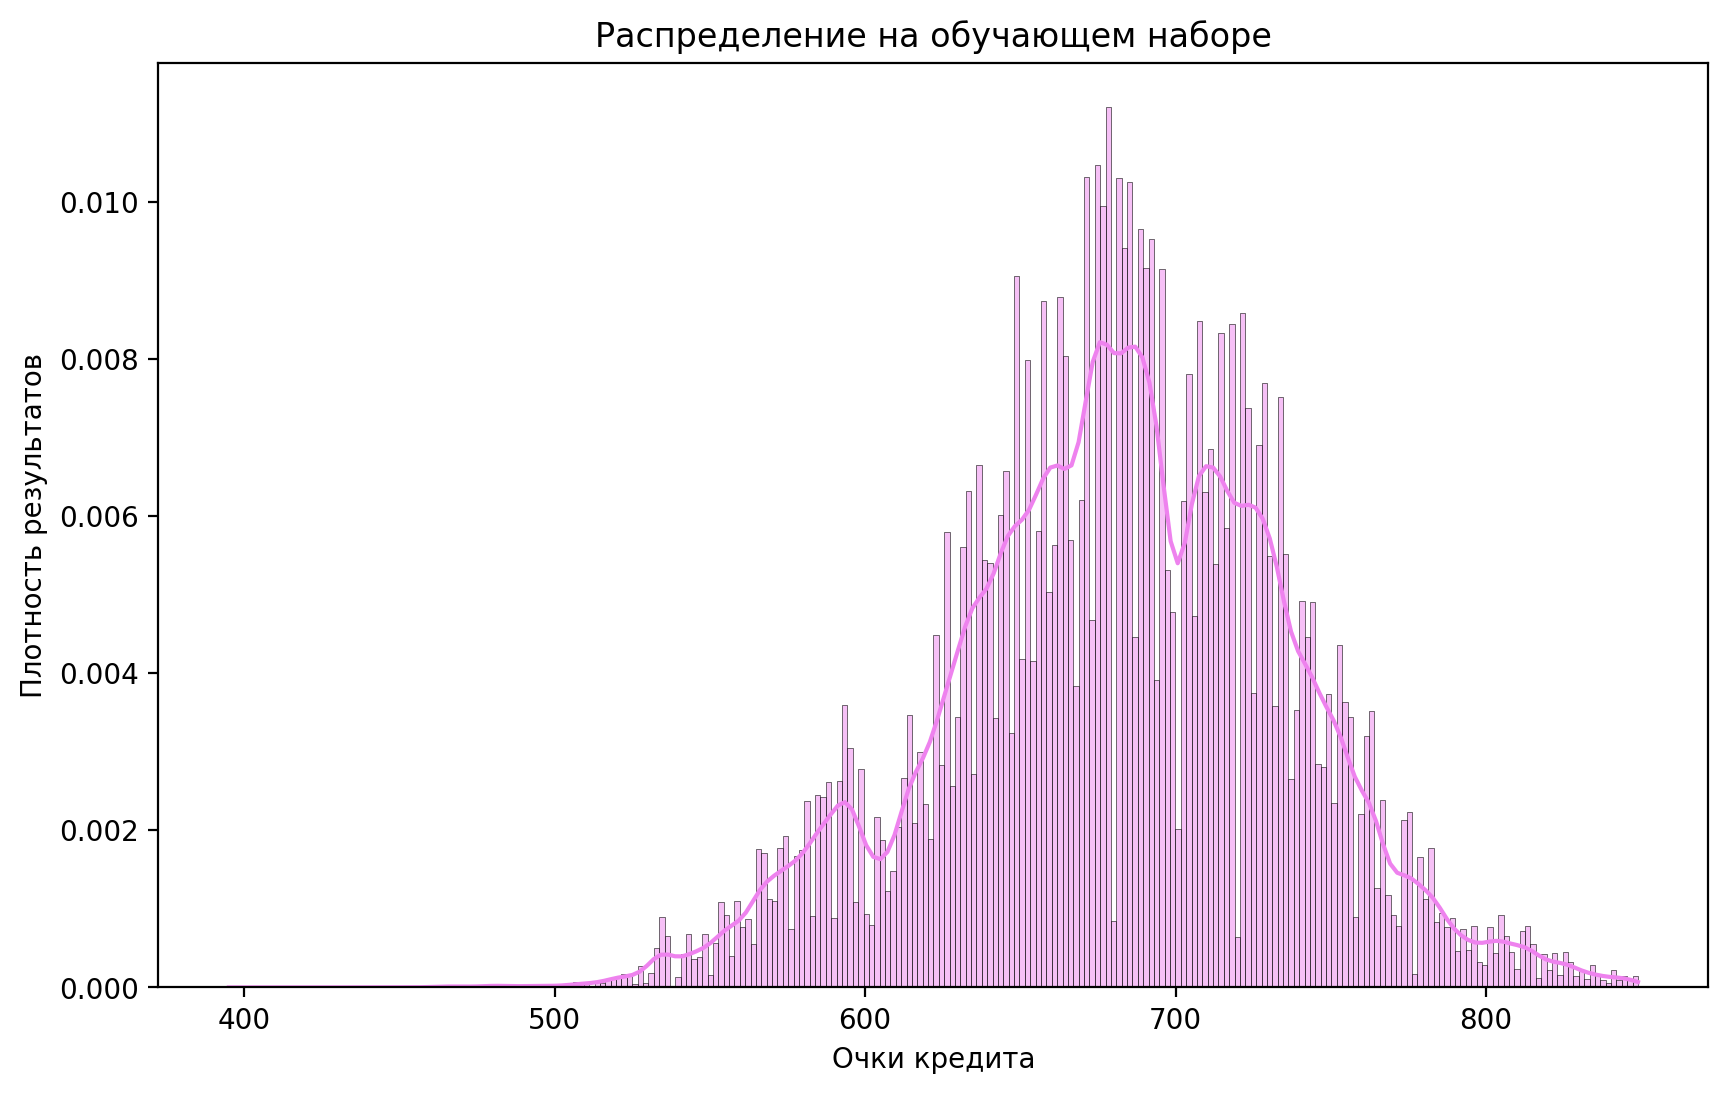

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(train["credit_score"], kde=True, color="violet", stat="density", alpha=0.5)
plt.xlabel("Очки кредита")
plt.ylabel("Плотность результатов")
plt.title("Распределение на обучающем наборе")
plt.show()

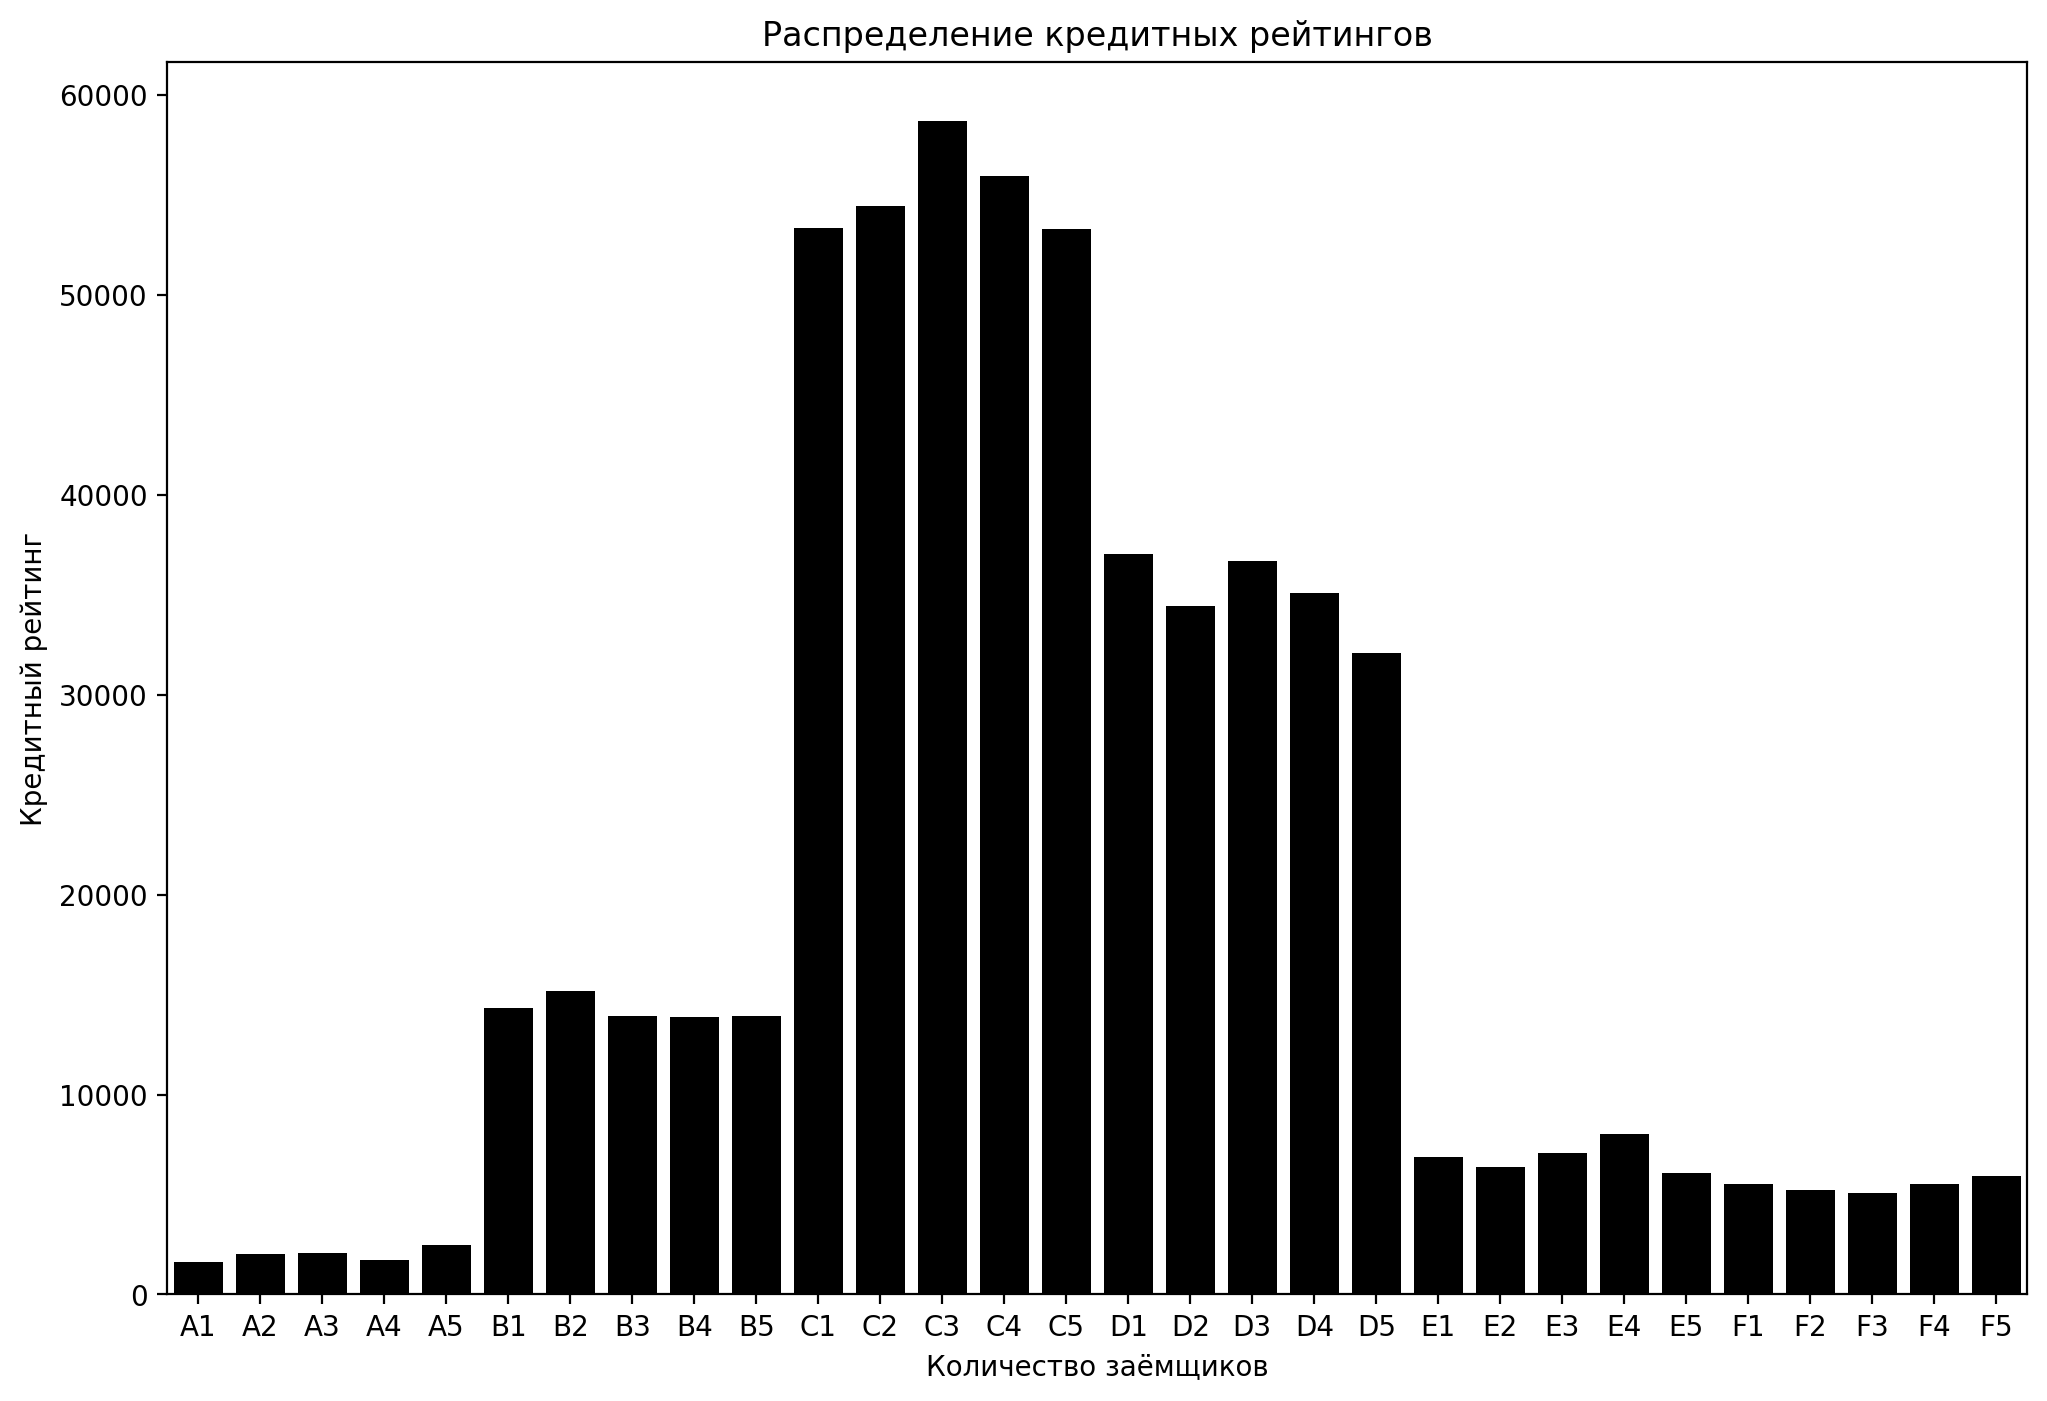

In [18]:
plt.figure(figsize=(12, 8))
sns.countplot(
    x=train["grade_subgrade"],
    color="black",
    order=sorted(train["grade_subgrade"].unique()),
)
plt.ylabel("Кредитный рейтинг")
plt.xlabel("Количество заёмщиков")
plt.title("Распределение кредитных рейтингов")
plt.show()

In [19]:
# Если 0 (дефолт), 1 (вернул кредит)
grade_stats = (
    train.groupby("grade_subgrade")["loan_paid_back"]
    .agg(
        [
            ("total", "count"),
            ("good_loans", "sum"),  # теперь суммируем хорошие кредиты
            ("good_rate", "mean"),  # среднее = процент хороших кредитов
        ]
    )
    .round(3)
)
grade_stats["defaults"] = grade_stats["total"] - grade_stats["good_loans"]
grade_stats["default_rate"] = grade_stats["defaults"] / grade_stats["total"]
print(grade_stats.sort_values("default_rate", ascending=False))

                total  good_loans  good_rate  defaults  default_rate
grade_subgrade                                                      
F3               5082      3070.0      0.604    2012.0      0.395907
F2               5203      3214.0      0.618    1989.0      0.382279
F1               5534      3456.0      0.625    2078.0      0.375497
F4               5535      3526.0      0.637    2009.0      0.362963
F5               5947      3802.0      0.639    2145.0      0.360686
E3               7075      4541.0      0.642    2534.0      0.358163
E4               8036      5220.0      0.650    2816.0      0.350423
E1               6891      4493.0      0.652    2398.0      0.347990
E2               6372      4223.0      0.663    2149.0      0.337257
E5               6084      4073.0      0.669    2011.0      0.330539
D3              36694     25538.0      0.696   11156.0      0.304028
D5              32101     22888.0      0.713    9213.0      0.287000
D4              35097     25085.0 

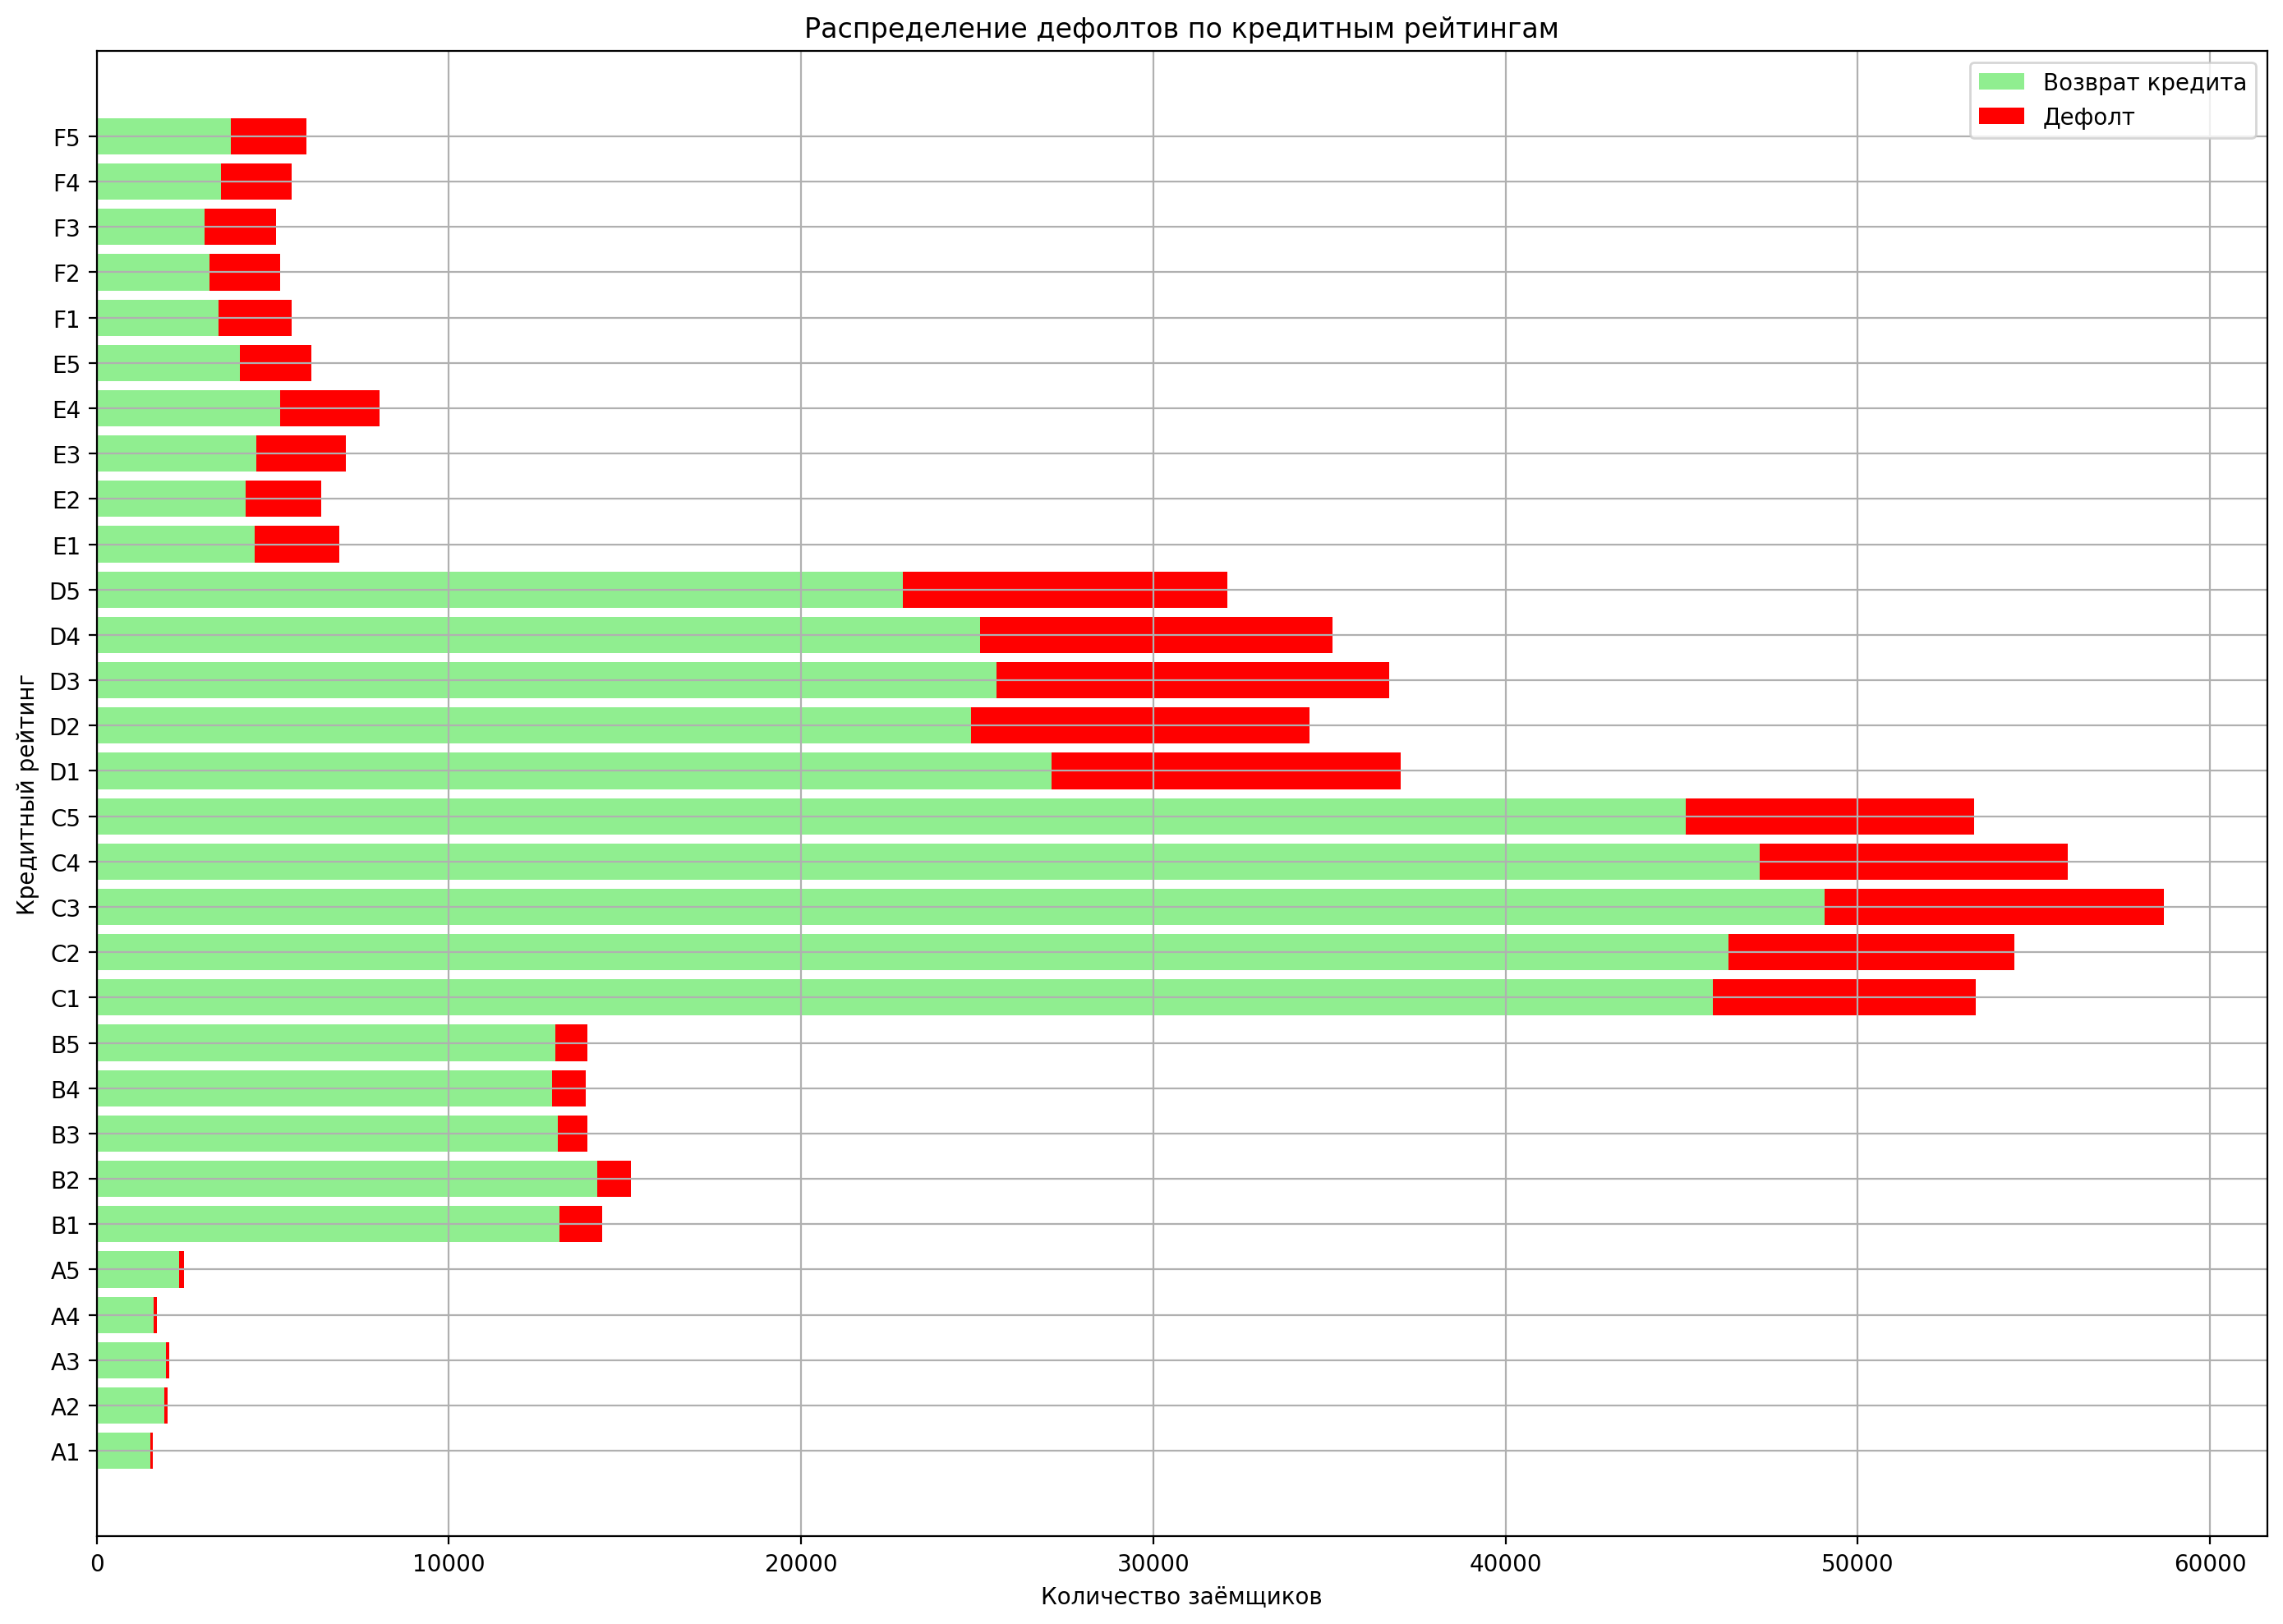

In [20]:
plt.figure(figsize=(14, 10))

# Сортируем по проценту дефолтов
sorted_stats = grade_stats.sort_values("grade_subgrade")

plt.barh(
    sorted_stats.index,
    sorted_stats["good_loans"],
    color="lightgreen",
    label="Возврат кредита",
)
plt.barh(
    sorted_stats.index,
    sorted_stats["defaults"],
    left=sorted_stats["good_loans"],
    color="red",
    label="Дефолт",
)

plt.xlabel("Количество заёмщиков")
plt.ylabel("Кредитный рейтинг")
plt.title("Распределение дефолтов по кредитным рейтингам")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

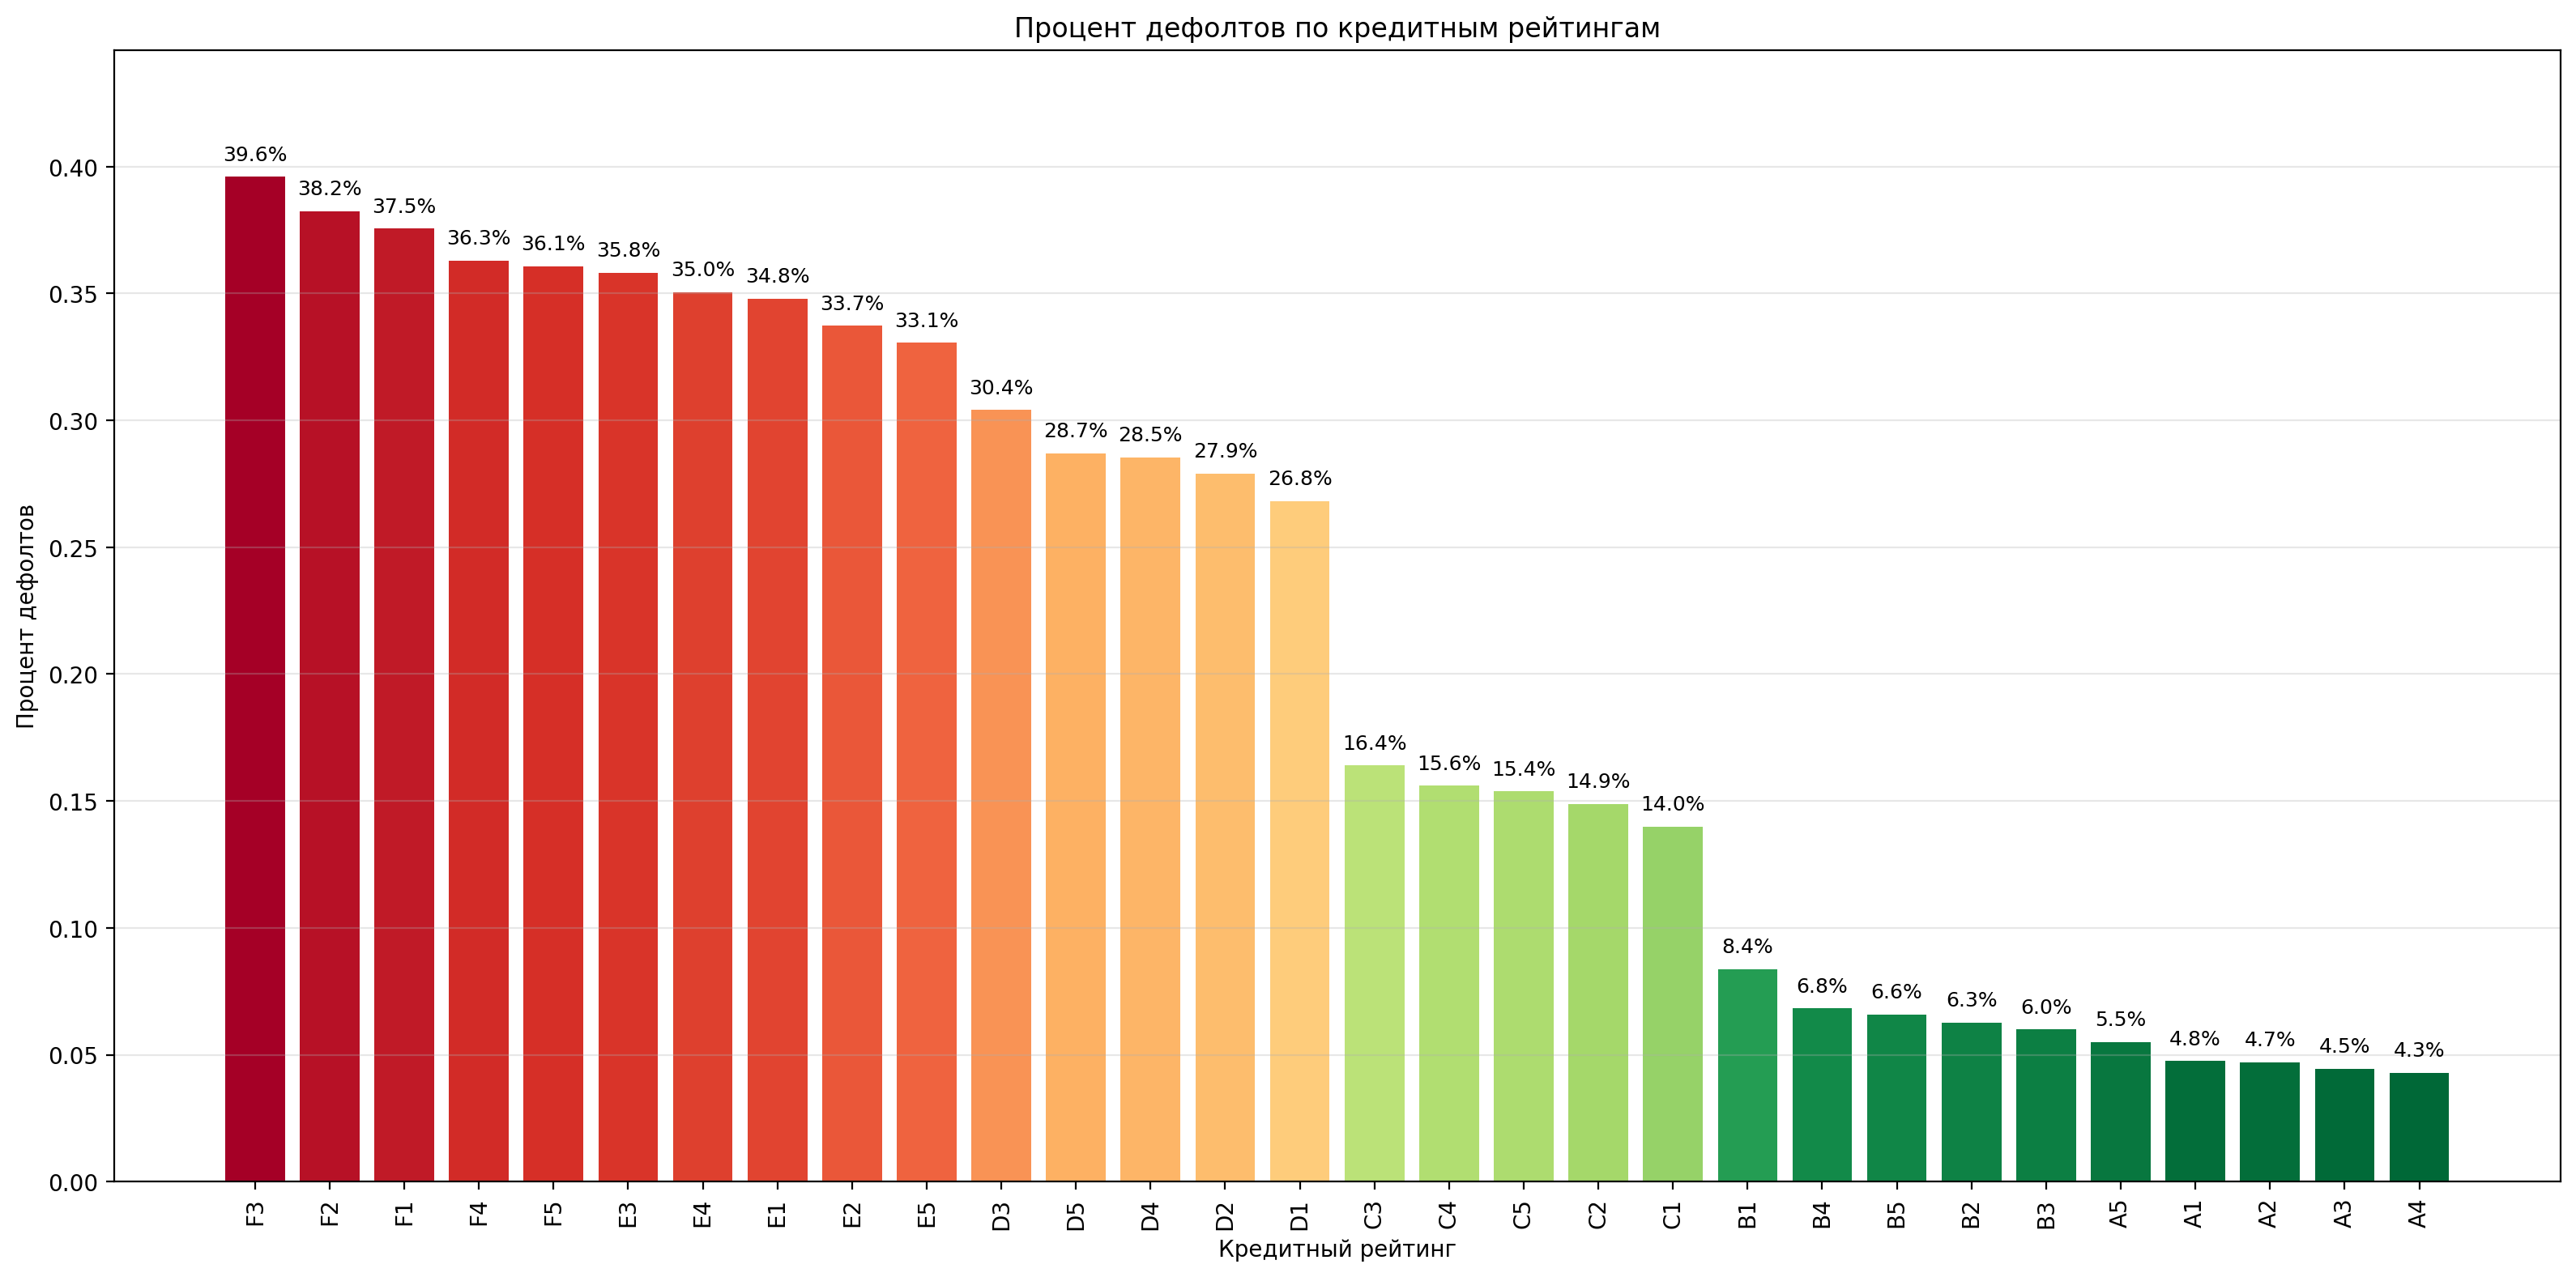

In [21]:
plt.figure(figsize=(16, 8))

sorted_stats = grade_stats.sort_values("default_rate", ascending=False)

# color scale
colors = plt.cm.RdYlGn_r(
    (sorted_stats["default_rate"] - sorted_stats["default_rate"].min())
    / (sorted_stats["default_rate"].max() - sorted_stats["default_rate"].min())
)

bars = plt.bar(range(len(sorted_stats)), sorted_stats["default_rate"], color=colors)

plt.ylabel("Процент дефолтов")
plt.xlabel("Кредитный рейтинг")
plt.title("Процент дефолтов по кредитным рейтингам")
plt.ylim(0, sorted_stats["default_rate"].max() + 0.05)


plt.xticks(range(len(sorted_stats)), sorted_stats.index, rotation=90)

# text and titles
for i, (grade, row) in enumerate(sorted_stats.iterrows()):
    plt.text(
        i,
        row["default_rate"] + 0.005,
        f'{row["default_rate"]:.1%}',
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:**
`grade_subgrade` - ключевой признак. добавим рассчитанный на основе его `default_rate`  в процессе создания новых фичей



## 3. Ключевая метрика и baseline

Ключевой метрикой эффективности разработанной модели кредитного скоринга в данном исследовании является показатель **ROC-AUC** (Receiver Operating Characteristic — Area Under the Curve).

Данная метрика отражает способность модели различать «надёжных» и «ненадёжных» заёмщиков независимо от выбранного порога классификации.
В отличие от точности (accuracy) или F1-меры, ROC-AUC оценивает качество ранжирования предсказанных вероятностей и позволяет корректно сравнивать модели даже при несбалансированных классах, что характерно для кредитных данных.

Таким образом, использование ROC-AUC обеспечивает объективную и устойчивую оценку качества классификации, что особенно важно при построении скоринговых систем, где критично минимизировать риск ошибочной выдачи кредита ненадёжному клиенту.

In [22]:
X = train.drop(columns=["loan_paid_back", "id"])
y = train["loan_paid_back"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=77, stratify=y
)


model_base = CatBoostClassifier(
    random_state=77, verbose=False, cat_features=categorical_columns.to_list()
)

model_base.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=100)

Learning rate set to 0.142946
0:	learn: 0.5386691	test: 0.5384044	best: 0.5384044 (0)	total: 229ms	remaining: 3m 48s
100:	learn: 0.2498416	test: 0.2493096	best: 0.2493096 (100)	total: 12.2s	remaining: 1m 48s
200:	learn: 0.2456624	test: 0.2460417	best: 0.2460417 (200)	total: 26.2s	remaining: 1m 44s
300:	learn: 0.2432099	test: 0.2447002	best: 0.2447002 (300)	total: 38.3s	remaining: 1m 28s
400:	learn: 0.2413930	test: 0.2441679	best: 0.2441674 (396)	total: 52.2s	remaining: 1m 17s
500:	learn: 0.2397917	test: 0.2436629	best: 0.2436628 (499)	total: 1m 6s	remaining: 1m 5s
600:	learn: 0.2382173	test: 0.2430560	best: 0.2430560 (600)	total: 1m 18s	remaining: 52.2s
700:	learn: 0.2370525	test: 0.2428916	best: 0.2428916 (700)	total: 1m 32s	remaining: 39.4s
800:	learn: 0.2358155	test: 0.2427098	best: 0.2427034 (794)	total: 1m 48s	remaining: 27s
900:	learn: 0.2346066	test: 0.2426029	best: 0.2425937 (894)	total: 2m 2s	remaining: 13.4s
999:	learn: 0.2335337	test: 0.2424883	best: 0.2424853 (966)	total: 2

In [23]:
# Предсказания
y_pred = model_base.predict(X_val)
y_pred_score = model_base.predict_proba(X_val)[:, 1]

# Оценка
print("ROC-AUC:", roc_auc_score(y_val, y_pred_score))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

ROC-AUC: 0.9233323061199381

Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.62      0.73     29875
         1.0       0.91      0.98      0.94    118624

    accuracy                           0.91    148499
   macro avg       0.90      0.80      0.84    148499
weighted avg       0.91      0.91      0.90    148499



In [24]:
# вывод основных метрик
def print_metrics(y_true, y_pred):
    """
    Вывод основных метрик модели
    и кривой ROC AUC

    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_score)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")

In [25]:
print_metrics(y_val, y_pred)

Accuracy: 0.9074
Precision: 0.9116
Recall: 0.9790
F1-score: 0.9441
ROC AUC: 0.9233


In [26]:
categorical_columns

Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object')

In [27]:
print(model_base.get_all_params()["learning_rate"])

0.1429460048675537


### 3.1 Подбор гиперпараметров  

In [28]:
X = train.drop(columns=["loan_paid_back", "id"])
y = train["loan_paid_back"]
cat_features = [
    "gender",
    "marital_status",
    "education_level",
    "employment_status",
    "loan_purpose",
    "grade_subgrade",
]

In [29]:
data_pool = Pool(data=X, label=y, cat_features=cat_features)

<div style="background-color: #fff3cd; border: 1px solid #ffeaa7; padding: 15px; border-radius: 5px; color: #856404;">
<strong>🐢⚠️ ВАЖНО / IMPORTANT</strong><br>
 КОД В СЛЕДУЮЩЕЙ ЯЧЕЙКЕ ВЫПОЛНЯЕТСЯ ДОЛГО! Его можно пропустить! ⏳<br>
 CODE IN NEXT CELL TAKES LONG TIME! You can skip it! ⏳
</div>

In [81]:
param_grid = {
    "depth": [4, 6]
    "learning_rate": [ 0.1, 0.15],
    "auto_class_weights": ["None", "Balanced"],
}

results = []

for depth in param_grid["depth"]:
    for lr in param_grid["learning_rate"]:
        for acw in param_grid["auto_class_weights"]:
            params = {
                "iterations": 1000,
                "depth": depth,
                "learning_rate": lr,
                "loss_function": "Logloss",
                "eval_metric": "AUC",
                "random_seed": 2007,
                "verbose": False,
                "auto_class_weights": acw,
            }

            cv_res = cv(
                pool=data_pool,
                params=params,
                fold_count=4,
                stratified=True,
                early_stopping_rounds=100,
                verbose=False,
            )

            auc_mean = cv_res["test-AUC-mean"].max()
            best_iter = int(cv_res["test-AUC-mean"].idxmax())

            results.append(
                {
                    "depth": depth,
                    "learning_rate": lr,
                    "auto_class_weights": acw,
                    "cv_auc": auc_mean,
                    "best_iter": best_iter,
                }
            )
            print(
                f"depth={depth}, lr={lr}, auto_class_weights={acw} -> AUC={auc_mean:.4f} @iter {best_iter}"
            )

results_df = (
    pd.DataFrame(results).sort_values("cv_auc", ascending=False).reset_index(drop=True)
)
display(results_df.head(10))

Training on fold [0/4]

bestTest = 0.9191889318
bestIteration = 999

Training on fold [1/4]

bestTest = 0.9189051159
bestIteration = 996

Training on fold [2/4]

bestTest = 0.9196436743
bestIteration = 999

Training on fold [3/4]

bestTest = 0.9217322364
bestIteration = 999

depth=4, lr=0.05, auto_class_weights=None -> AUC=0.9199 @iter 999
Training on fold [0/4]

bestTest = 0.9193925755
bestIteration = 997

Training on fold [1/4]

bestTest = 0.9190945946
bestIteration = 998

Training on fold [2/4]

bestTest = 0.9198869778
bestIteration = 999

Training on fold [3/4]

bestTest = 0.9219340053
bestIteration = 998

depth=4, lr=0.05, auto_class_weights=Balanced -> AUC=0.9201 @iter 999
Training on fold [0/4]

bestTest = 0.9209953695
bestIteration = 985

Training on fold [1/4]

bestTest = 0.9209497203
bestIteration = 997

Training on fold [2/4]

bestTest = 0.9218618286
bestIteration = 999

Training on fold [3/4]

bestTest = 0.9233536722
bestIteration = 998

depth=4, lr=0.1, auto_class_weights=

,depth,learning_rate,auto_class_weights,cv_auc,best_iter
0,4,0.15,Balanced,0.923111,999
1,6,0.15,Balanced,0.923063,989
2,6,0.15,None,0.922986,997
3,6,0.10,Balanced,0.922870,998
4,4,0.15,None,0.922750,999
5,6,0.10,None,0.922604,999
6,8,0.10,Balanced,0.922441,844
7,8,0.10,None,0.922416,999
8,8,0.15,None,0.922343,817
9,4,0.10,Balanced,0.922268,999


In [83]:
# Лучшая комбинация
best = results_df.iloc[0].to_dict()
best

{'depth': 4,
 'learning_rate': 0.15,
 'auto_class_weights': 'Balanced',
 'cv_auc': 0.9231112015101609,
 'best_iter': 999}

In [80]:
train.head(2)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0


### 3.2 Feature engineering

In [30]:
grade_stats = grade_stats.reset_index()

In [32]:
def add_features(df):
    """
    новые признаки для модели кредитного скоринга.
    """
    df = df.copy()

    # отношение кредита и дохода
    df["loan_to_income"] = df["loan_amount"] / (df["annual_income"] + 1e-6)

    # эффективная нагрузка с учётом процентов
    df["debt_interest_ratio"] = (
        df["loan_amount"] * (1 + df["interest_rate"] / 100)
    ) / (df["annual_income"] + 1e-6)

    # лог-преобразования (нормализация распределений)
    df["log_annual_income"] = np.log1p(df["annual_income"])
    df["log_loan_amount"] = np.log1p(df["loan_amount"])

    # отношение долга к кредитному рейтингу
    df["debt_score_ratio"] = df["debt_to_income_ratio"] / (df["credit_score"] + 1e-6)

    #  Новые интеракционные фичи
    df["credit_risk_index"] = df["credit_score"] * (1 - df["debt_to_income_ratio"])
    df["loan_income_stress"] = df["loan_amount"] / (
        df["annual_income"] * df["debt_to_income_ratio"] + 1e-6
    )

    # признак default_rate по grade_subgrade (при наличии grade_stats)
    if grade_stats is not None:
        df["grade_subgrade"] = df["grade_subgrade"].astype(str).str.strip().str.upper()
        grade_stats["grade_subgrade"] = (
            grade_stats["grade_subgrade"].astype(str).str.strip().str.upper()
        )
    return df

In [33]:
train_fe_added = add_features(train)

In [34]:
def add_combined_rating(df):
    """
    Создаёт числовой рейтинг заемщика на основе grade_subgrade.
    Чем выше combined_rating, тем надёжнее клиент.
    """
    df = df.copy()

    # Карта соответствия буквенного рейтинга
    grade_map = {"A": 7, "B": 6, "C": 5, "D": 4, "E": 3, "F": 2, "G": 1}

    # Разделяем grade и subgrade
    df["grade"] = df["grade_subgrade"].str[0]
    df["subgrade"] = df["grade_subgrade"].str[1:].astype(int)

    # Числовое представление: чем выше grade — тем лучше
    df["grade_num"] = df["grade"].map(grade_map)

    # Итоговый рейтинг (чем выше — тем надёжнее)
    df["combined_rating"] = df["grade_num"] + (1 - df["subgrade"] / 10)

    return df

In [55]:
train_fe_added = add_combined_rating(train_fe_added)

In [36]:
features_added = list(set(train_fe_added.columns) - set(train.columns))
print(f"Исходное количество фич: {train.shape[1]}")
print(f"После добавления: {train_fe_added.shape[1]}")
print(f"Добавлено фич: {len(features_added)}")
print("Новые фичи:", features_added)

Исходное количество фич: 13
После добавления: 25
Добавлено фич: 12
Новые фичи: ['subgrade', 'log_annual_income', 'loan_income_stress', 'credit_risk_index', 'debt_score_ratio', 'default_rate', 'grade', 'log_loan_amount', 'grade_num', 'loan_to_income', 'debt_interest_ratio', 'combined_rating']


In [56]:
train_fe_added.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,loan_to_income,debt_interest_ratio,log_annual_income,log_loan_amount,debt_score_ratio,credit_risk_index,loan_income_stress,grade,subgrade,grade_num,combined_rating
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0,0.086094,0.097864,10.287695,7.835745,0.000114,674.176,1.024934,C,3,5,5.7
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0,0.207757,0.234599,10.003741,8.432528,0.000261,530.424,1.251549,D,3,4,4.7
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0,0.343080,0.376564,10.811085,9.741330,0.000140,626.682,3.536903,C,5,5,5.5
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0,0.099929,0.116017,10.754904,8.451797,0.000122,498.355,1.537363,F,1,2,2.9
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0,0.477883,0.526674,10.146344,9.407996,0.000080,629.755,9.016653,D,1,4,4.9


In [35]:
phik_overview = train_fe_added.phik_matrix()
phik_overview["loan_paid_back"].drop("loan_paid_back").sort_values(
    ascending=False
).to_frame()

interval columns not set, guessing: ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_paid_back', 'loan_to_income', 'debt_interest_ratio', 'log_annual_income', 'log_loan_amount', 'debt_score_ratio', 'credit_risk_index', 'loan_income_stress']


,loan_paid_back
employment_status,0.542458
credit_risk_index,0.499260
debt_score_ratio,0.476429
debt_to_income_ratio,0.435194
credit_score,0.302618
grade_subgrade,0.286757
interest_rate,0.168863
loan_income_stress,0.034595
loan_purpose,0.033892
log_loan_amount,0.031056


Сравним качество модели ДО и ПОСЛЕ применения новых признаков. оставим следующие признаки, удалив слабые:

In [36]:
cat_features = [
    "employment_status",
    "loan_purpose",
    "grade_subgrade",
    "education_level",
]
num_features = [
    "debt_to_income_ratio",
    "credit_score",
    "credit_risk_index",
    "loan_income_stress",
    "debt_score_ratio",
    "interest_rate",
    "log_loan_amount",
    "log_annual_income",
    "annual_income",
    "loan_amount",
]
used_features = cat_features + num_features

In [37]:
X = train_fe_added[used_features]
y = train_fe_added["loan_paid_back"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=2007, stratify=y
)

In [38]:
params = {
    "iterations": 1200,
    "depth": 4,
    "learning_rate": 0.17,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": 2007,
    "verbose": 100,
    "auto_class_weights": "Balanced",
    "early_stopping_rounds": 50,
    "l2_leaf_reg": 3.0,
}

In [39]:
model_fe = CatBoostClassifier(**params, cat_features=cat_features)
model_fe.fit(X_train, y_train, eval_set=(X_valid, y_valid))

0:	test: 0.8940313	best: 0.8940313 (0)	total: 118ms	remaining: 2m 21s
100:	test: 0.9162932	best: 0.9162932 (100)	total: 10.1s	remaining: 1m 49s
200:	test: 0.9186300	best: 0.9186300 (200)	total: 18.4s	remaining: 1m 31s
300:	test: 0.9201578	best: 0.9201578 (300)	total: 26.5s	remaining: 1m 19s
400:	test: 0.9209076	best: 0.9209142 (399)	total: 35.2s	remaining: 1m 10s
500:	test: 0.9215428	best: 0.9215428 (500)	total: 44s	remaining: 1m 1s
600:	test: 0.9217967	best: 0.9217978 (599)	total: 53.6s	remaining: 53.5s
700:	test: 0.9220410	best: 0.9220445 (699)	total: 1m 2s	remaining: 44.8s
800:	test: 0.9221915	best: 0.9221915 (800)	total: 1m 12s	remaining: 36s
900:	test: 0.9222556	best: 0.9222700 (895)	total: 1m 21s	remaining: 27s
1000:	test: 0.9223135	best: 0.9223135 (1000)	total: 1m 30s	remaining: 18s
1100:	test: 0.9223745	best: 0.9223767 (1095)	total: 1m 39s	remaining: 8.93s
1199:	test: 0.9225186	best: 0.9225186 (1199)	total: 1m 47s	remaining: 0us

bestTest = 0.9225186498
bestIteration = 1199



In [40]:
y_pred_fe = model_fe.predict(X_valid)
y_pred_score = model_fe.predict_proba(X_valid)[:, 1]
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_fe))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.79      0.71     29875
         1.0       0.94      0.89      0.92    118624

    accuracy                           0.87    148499
   macro avg       0.80      0.84      0.81    148499
weighted avg       0.88      0.87      0.88    148499



In [41]:
print_metrics(y_valid, y_pred_fe)

Accuracy: 0.8711
Precision: 0.9442
Recall: 0.8913
F1-score: 0.9170
ROC AUC: 0.9225


нет переобучения, ROC-AUC держится около 0.923–0.928 независимо от состава фичей.
Это значит, что:

признаки теперь охватывают почти всё информативное пространство;

дальнейший рост AUC возможен только за счёт подбора гиперпараметров (регуляризация, глубина, итерации).
Осуществим это с помощью  CV но изменив сетку параметров пл сравнению с пунктом 3.1

### 3.3 CV + Hyperparameter Tuning for final model


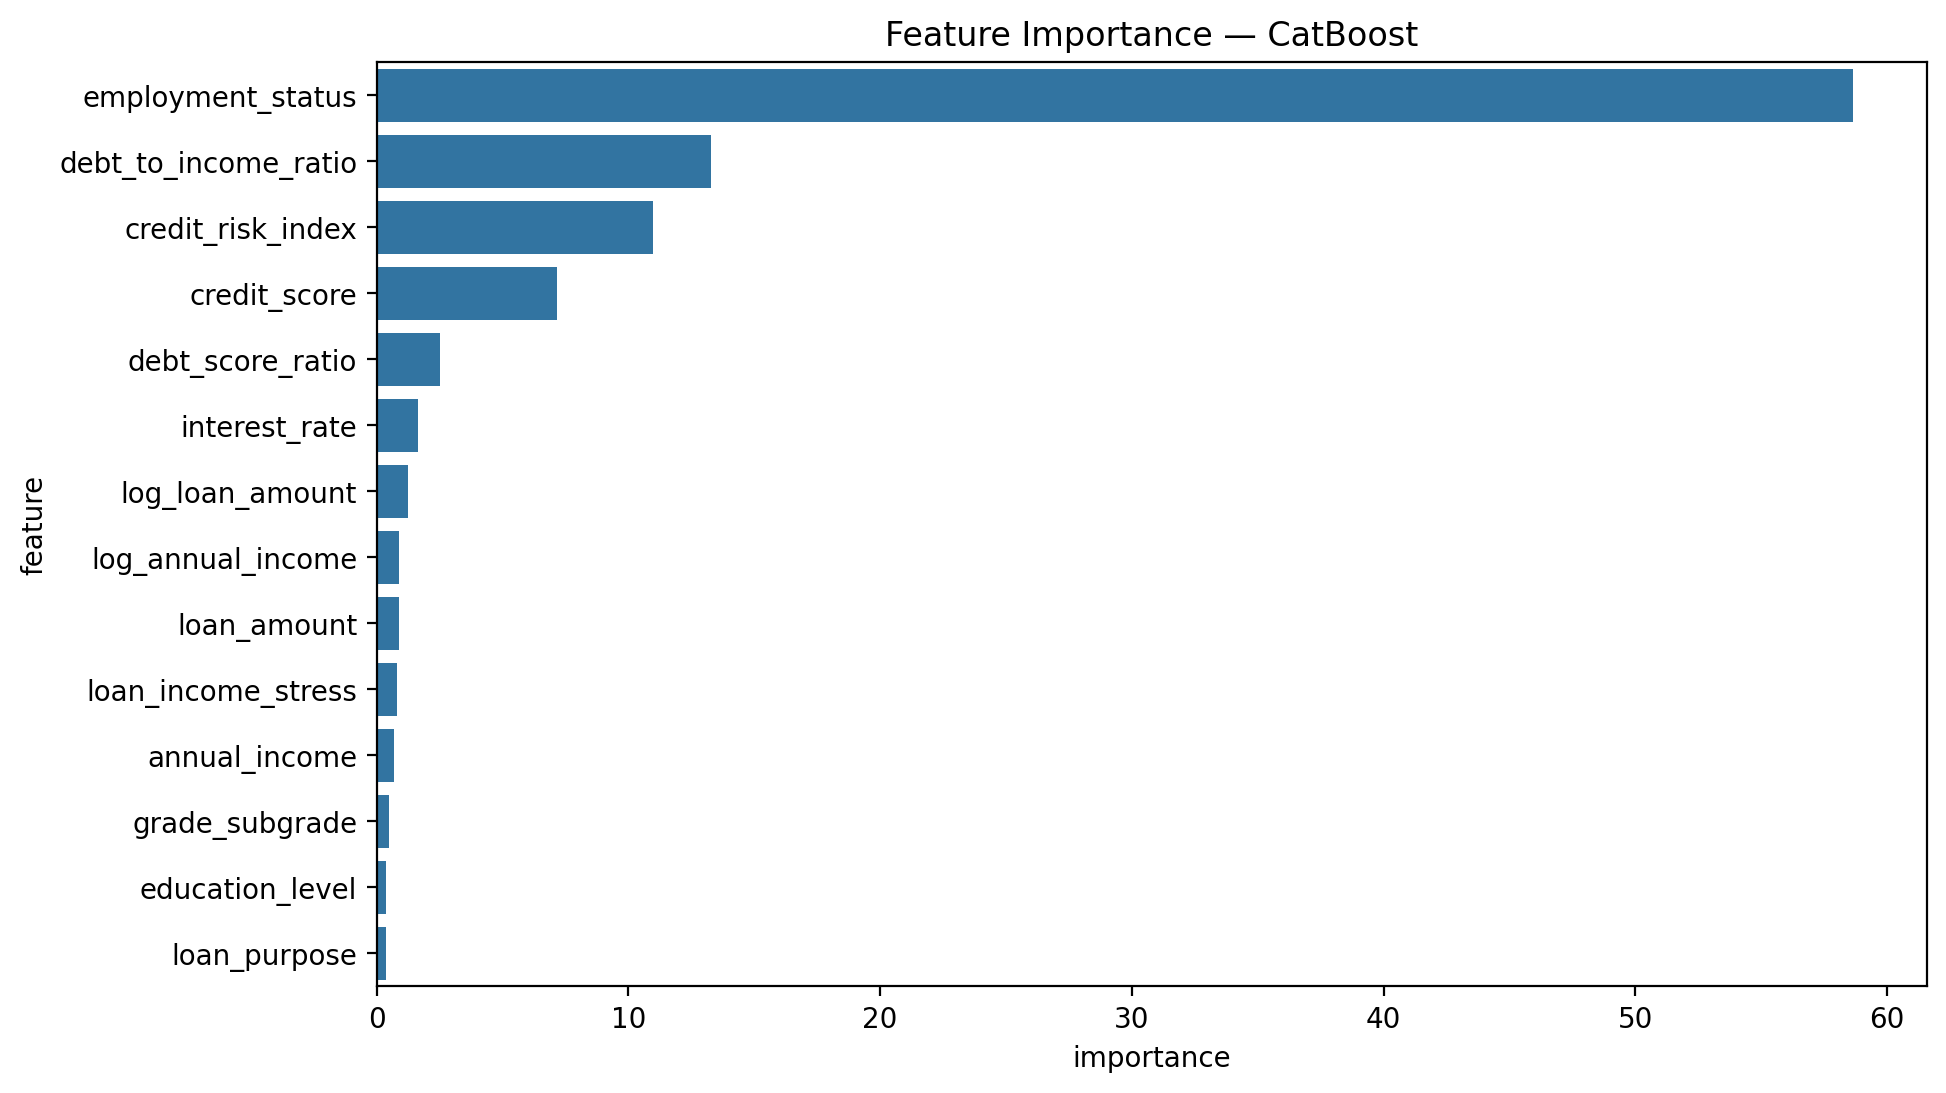

In [42]:
fi = pd.DataFrame(
    {"feature": X.columns, "importance": model_fe.get_feature_importance()}
).sort_values("importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="importance", y="feature", data=fi.head(15))
plt.title("Feature Importance — CatBoost")
plt.show()

In [43]:
display(fi.head(15))

,feature,importance
0,employment_status,58.640062
4,debt_to_income_ratio,13.271977
6,credit_risk_index,10.986822
5,credit_score,7.178025
8,debt_score_ratio,2.496910
9,interest_rate,1.648871
10,log_loan_amount,1.252259
11,log_annual_income,0.899604
13,loan_amount,0.897962
7,loan_income_stress,0.805468


In [44]:
X = train_fe_added[used_features]
y = train_fe_added["loan_paid_back"]

# пул данных
data_pool = Pool(X, label=y, cat_features=cat_features)

In [45]:
param_grid = {
    "depth": [4, 5],
    "learning_rate": [0.125, 0.145],
    "l2_leaf_reg": [3.0, 4.0, 5.0],
}

<div style="background-color: #fff3cd; border: 1px solid #ffeaa7; padding: 15px; border-radius: 5px; color: #856404;">
<strong>🐢⚠️ ВАЖНО / IMPORTANT</strong><br>
 КОД В СЛЕДУЮЩЕЙ ЯЧЕЙКЕ ВЫПОЛНЯЕТСЯ ДОЛГО! Его можно пропустить! ⏳<br>
 CODE IN NEXT CELL TAKES LONG TIME! You can skip it! ⏳
</div>

In [46]:
results = []

for depth in param_grid["depth"]:
    for lr in param_grid["learning_rate"]:
        for reg in param_grid["l2_leaf_reg"]:
            params = {
                "iterations": 1400,
                "depth": depth,
                "learning_rate": lr,
                "loss_function": "Logloss",
                "eval_metric": "AUC",
                "random_seed": 2007,
                "verbose": False,
                "subsample": 0.8,
                "auto_class_weights": "Balanced",
                "l2_leaf_reg": reg,
                "early_stopping_rounds": 100,
            }

            cv_res = cv(
                pool=data_pool,
                params=params,
                fold_count=5,
                stratified=True,
                verbose=False,
            )

            auc_mean = cv_res["test-AUC-mean"].max()
            best_iter = int(cv_res["test-AUC-mean"].idxmax())

            results.append(
                {
                    "depth": depth,
                    "learning_rate": lr,
                    "l2_leaf_reg": reg,
                    "cv_auc": auc_mean,
                    "best_iter": best_iter,
                }
            )
            print(
                f"depth={depth}, lr={lr}, reg={reg} -> AUC={auc_mean:.4f} @iter {best_iter}"
            )

# === Таблица результатов ===
results_df = (
    pd.DataFrame(results).sort_values("cv_auc", ascending=False).reset_index(drop=True)
)
display(results_df.head(10))

# === Лучшая комбинация ===
best = results_df.iloc[0].to_dict()
print("\n🎯 Лучшие параметры:")
for k, v in best.items():
    print(f"{k}: {v}")

Training on fold [0/5]

bestTest = 0.9221076131
bestIteration = 1359

Training on fold [1/5]

bestTest = 0.922379896
bestIteration = 1386

Training on fold [2/5]

bestTest = 0.9221396891
bestIteration = 1344

Training on fold [3/5]

bestTest = 0.9237151941
bestIteration = 1396

Training on fold [4/5]

bestTest = 0.9253187876
bestIteration = 1393

depth=4, lr=0.125, reg=3.0 -> AUC=0.9231 @iter 1396
Training on fold [0/5]

bestTest = 0.9223593077
bestIteration = 1387

Training on fold [1/5]

bestTest = 0.9222848912
bestIteration = 1375

Training on fold [2/5]

bestTest = 0.9222091057
bestIteration = 1395

Training on fold [3/5]

bestTest = 0.923668075
bestIteration = 1399

Training on fold [4/5]

bestTest = 0.9252689349
bestIteration = 1397

depth=4, lr=0.125, reg=4.0 -> AUC=0.9232 @iter 1395
Training on fold [0/5]

bestTest = 0.9222558328
bestIteration = 1392

Training on fold [1/5]

bestTest = 0.9223785292
bestIteration = 1375

Training on fold [2/5]

bestTest = 0.92220747
bestIteratio

,depth,learning_rate,l2_leaf_reg,cv_auc,best_iter
0,4,0.145,3.0,0.923207,1392
1,4,0.145,5.0,0.923205,1397
2,4,0.145,4.0,0.923175,1394
3,4,0.125,4.0,0.923153,1395
4,4,0.125,5.0,0.923127,1399
5,4,0.125,3.0,0.923121,1396
6,5,0.145,4.0,0.923111,1269
7,5,0.145,5.0,0.923108,1291
8,5,0.125,3.0,0.923098,1386
9,5,0.125,5.0,0.923065,1365



🎯 Лучшие параметры:
depth: 4.0
learning_rate: 0.145
l2_leaf_reg: 3.0
cv_auc: 0.9232065339483118
best_iter: 1392.0


In [47]:
final_params = {
    "iterations": 1392,
    "depth": 4.0,
    "learning_rate": 0.145,
    "l2_leaf_reg": 3.0,
    "colsample_bylevel": 0.8,
    "subsample": 0.8,
    "auto_class_weights": "Balanced",
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": 2007,
    "verbose": 200,
    "bagging_temperature": 0.3,
}

In [48]:
final_model = CatBoostClassifier(**final_params)
final_model.fit(X, y, cat_features=cat_features)

0:	total: 347ms	remaining: 8m 2s
200:	total: 19.5s	remaining: 1m 55s
400:	total: 40s	remaining: 1m 38s
600:	total: 1m	remaining: 1m 19s
800:	total: 1m 20s	remaining: 59.4s
1000:	total: 1m 38s	remaining: 38.5s
1200:	total: 1m 58s	remaining: 18.8s
1391:	total: 2m 16s	remaining: 0us


### 3.4 Подбор оптимального порога классификации


Этапы подбора порога:

Получение вероятностей — вычисляем model.predict_proba() на всей выборке.

Оптимизация порога — перебираем возможные значения и оцениваем метрику (чаще всего F1-score или метрики Precision/Recall), выбирая порог, обеспечивающий наилучший баланс между полнотой и точностью классификации.

Фиксация порога — найденный порог используется для получения бинарных предсказаний на тестовой выборке или в продакшн-среде:

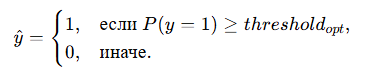

Таким образом, ROC-AUC используется для оценки способности модели к ранжированию, а F1-score и производные метрики — для определения практического порога принятия решения.ь

In [49]:
# scores для вероятностей (на тренировке или валидации):
train["y_score"] = final_model.predict_proba(X)[:, 1]
y_true = y

In [50]:
# перебираем пороги
unique_thresholds = np.linspace(0, 1, 101)
f1_scores = []
auc_scores = []

for t in unique_thresholds:
    y_pred = (train["y_score"] >= t).astype(int)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(
        y_true, train["y_score"]
    )  # AUC не зависит от порога, но для примера оставим
    f1_scores.append(f1)
    auc_scores.append(auc)

results_df = pd.DataFrame(
    {"threshold": unique_thresholds, "f1": f1_scores, "auc": auc_scores}
)


best_idx = results_df["f1"].idxmax()
best_threshold = results_df.loc[best_idx, "threshold"]
best_f1 = results_df.loc[best_idx, "f1"]

print(f"🎯 Лучший порог: {best_threshold:.3f}")
print(f"F1 при этом пороге: {best_f1:.4f}")

🎯 Лучший порог: 0.200
F1 при этом пороге: 0.9445


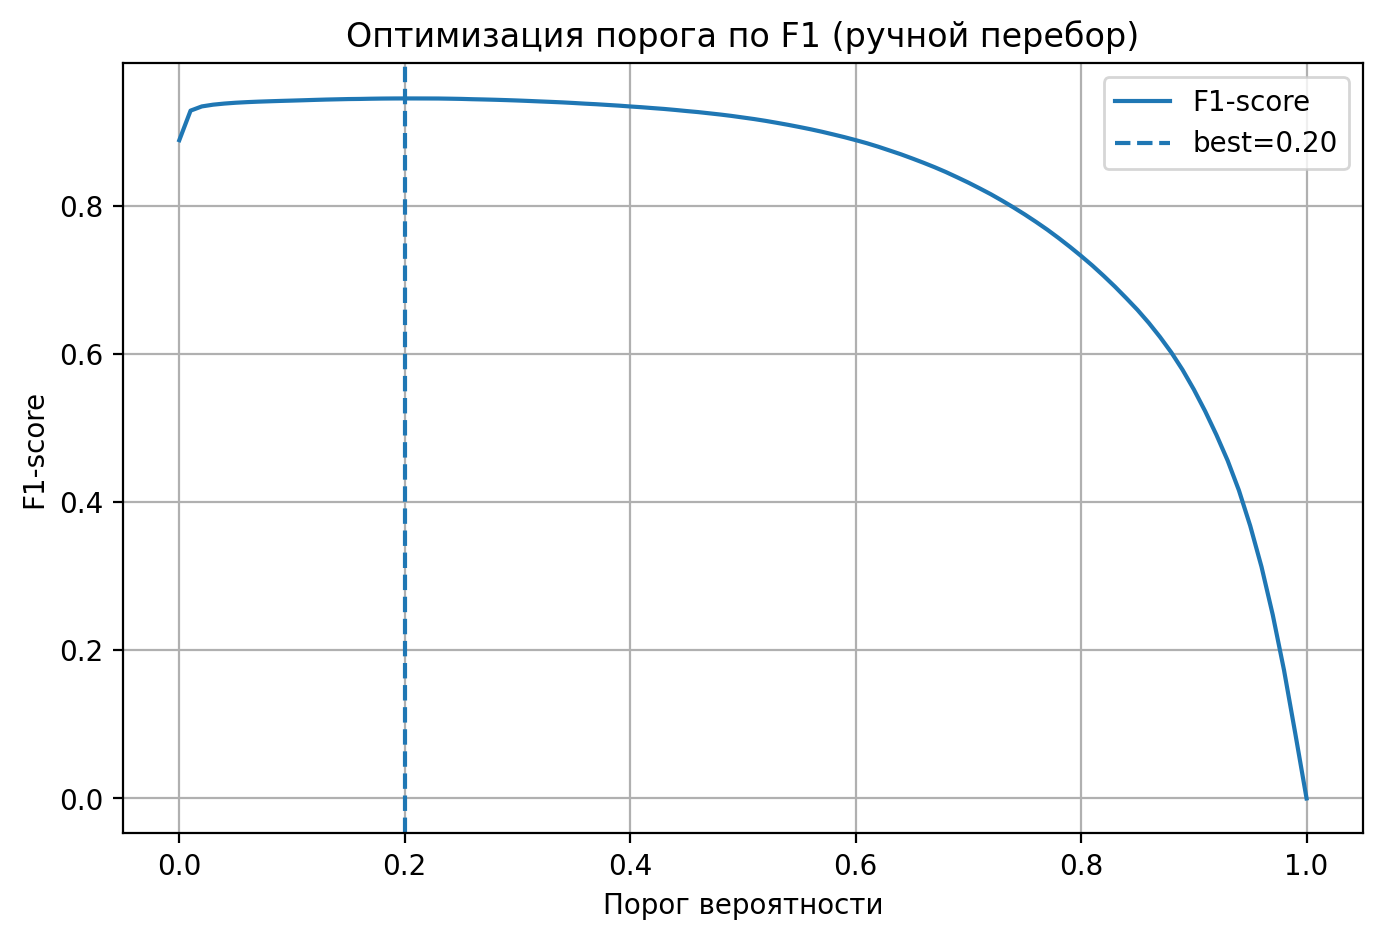

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(unique_thresholds, f1_scores, label="F1-score")
plt.axvline(best_threshold, linestyle="--", label=f"best={best_threshold:.2f}")
plt.xlabel("Порог вероятности")
plt.ylabel("F1-score")
plt.title("Оптимизация порога по F1 (ручной перебор)")
plt.legend()
plt.grid(True)
plt.show()

Cделаем итоговое предсказание с полученной модельб, предварительно подготовив выборку **test**

In [52]:
test_fe = add_features(test)

In [53]:
test_fe = add_combined_rating(test_fe)
test_fe.head(3)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_to_income,debt_interest_ratio,log_annual_income,log_loan_amount,debt_score_ratio,credit_risk_index,loan_income_stress,grade,subgrade,grade_num,combined_rating
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5,0.398228,0.456887,10.267507,9.346829,0.000078,595.326,8.127102,D,5,4,4.5
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1,0.332264,0.374959,10.749943,9.648160,0.000127,663.924,3.572726,C,1,5,5.9
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1,0.069082,0.078263,10.914286,8.242075,0.000601,386.763,0.188235,D,1,4,4.9


In [54]:
X_test = test_fe[used_features]
# Получаем вероятности
test_fe["y_score"] = final_model.predict_proba(X_test)[:, 1]

In [55]:
prob_sub = test_fe[["id", "y_score"]].copy()
prob_sub.columns = ["id", "loan_paid_back"]

In [56]:
prob_sub.to_csv("submission_v3.csv", index=False)


**Score: 0.92322** оценка на тестовой выборке

In [75]:
y_score_test = final_model.predict_proba(X_test)[:, 1]
test_fe["loan_paid_back"] = (y_score_test > 0.200).astype(int)  # применяем лучший порог
test_fe = test_fe.drop("y_score", axis=1)

## 4.  SHAP values


In [85]:
!pip install shap -q
!pip install --upgrade numba -q

Оси:

Y-ось — список признаков (features), отсортированных по средней силе влияния на модель.
→ чем выше в списке, тем важнее признак для модели.

X-ось (SHAP value) — вклад признака в отклонение прогноза от среднего значения.

Значения > 0 (вправо) → повышают вероятность класса 1 (кредит будет выплачен).

Значения < 0 (влево) → повышают вероятность класса 0 (дефолт).

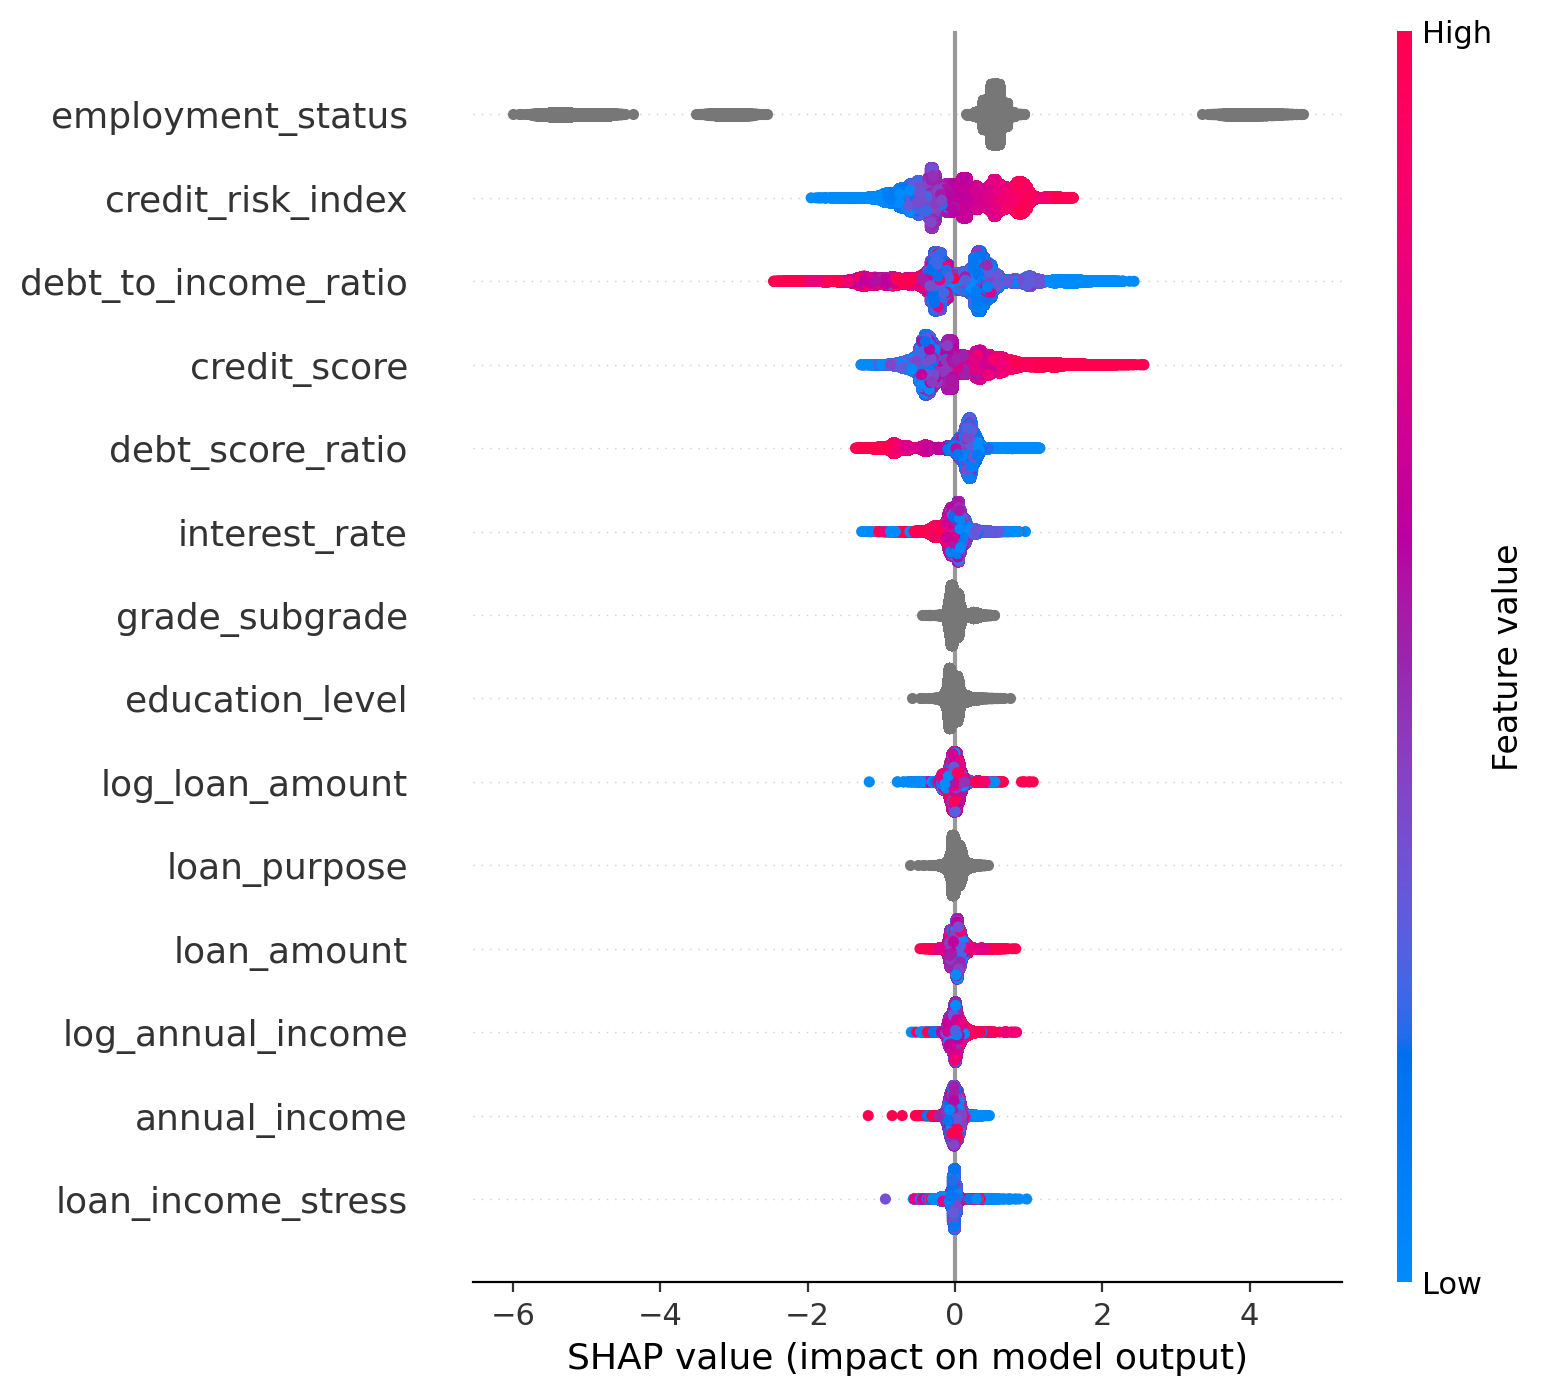

In [94]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

| Признак                           | Интерпретация                                                                                                                                                             |
| --------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **employment_status**             | Самый важный фактор. Видно, что определённые категории (например, *Employed* или *Self-employed*) дают сильное положительное влияние (точки справа). Безработные — слева. |
| **credit_risk_index**             | Чем выше индекс (красные точки справа) → тем выше шанс возврата кредита. Низкие значения (синие слева) — повышают риск дефолта.                                           |
| **debt_to_income_ratio**          | Чем выше отношение долга к доходу (красное слева) → тем **хуже** (двигает прогноз влево). Низкие значения — наоборот.                                                     |
| **credit_score**                  | Аналогично: высокий `credit_score` (красное справа) увеличивает вероятность выплаты.                                                                                      |
| **debt_score_ratio**              | Комбинированный показатель риска — работает в ту же сторону, что и кредитный рейтинг.                                                                                     |
| **interest_rate**                 | Высокая ставка (красное слева) → чаще указывает на риск (более дорогой кредит).                                                                                           |
| **education_level**               | Есть лёгкий сигнал: вероятно, более высокий уровень образования (красное справа) немного снижает риск.                                                                    |
| **loan_amount / log_loan_amount** | Чем больше сумма кредита (красное слева), тем выше риск невыплаты.                                                                                                        |
| **log_annual_income**             | Чем выше доход (красное справа), тем больше вероятность выплаты.                                                                                                          |


In [96]:
# выведем расчет предсказания для одного заемщика
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X.iloc[0, :])

Серая вертикальная линия (base value) — базовое среднее предсказание модели по всем данным.
 ≈ 0.8333 (средний шанс выплаты кредита).

Красные стрелки → признаки, которые увеличили вероятность выплаты (f(x) стал выше).

Синие стрелки ← признаки, которые уменьшили вероятность выплаты.

f(x) = 1.23 — финальный “логит” (в пространстве до сигмоиды).
После преобразования в вероятность это значение ≈ 0.77,
то есть модель оценивает 77% шанс, что кредит будет выплачен.

<Figure size 1600x1600 with 0 Axes>

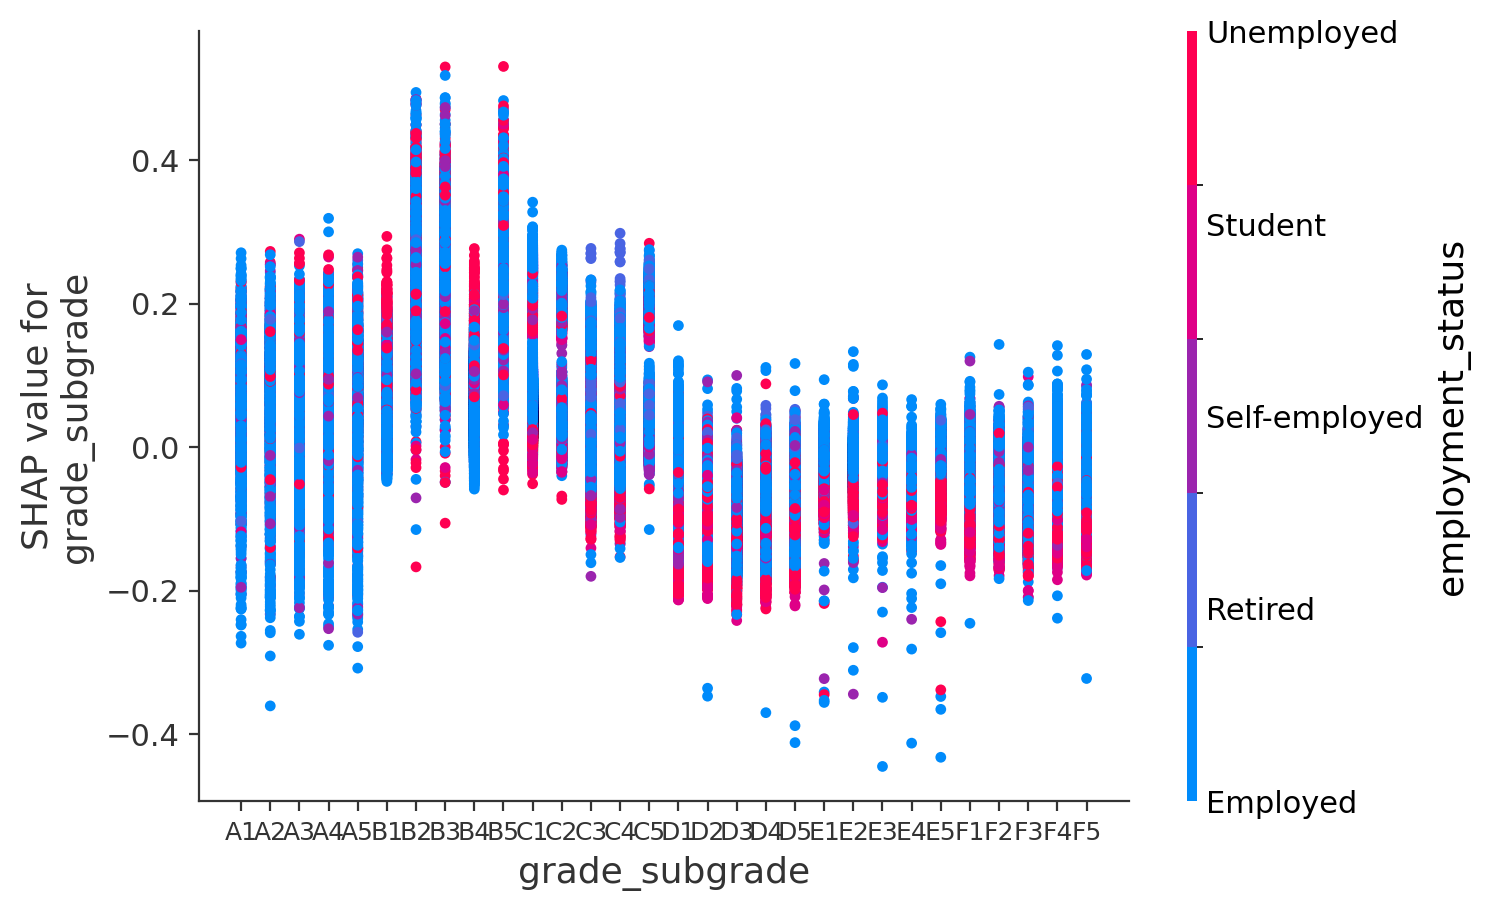

In [133]:
plt.figure(figsize=(16, 16))
shap.dependence_plot(
    "grade_subgrade",
    shap_values,
    X,
    interaction_index="employment_status",
    dot_size=15,
    show=False,
)
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_rotation(0)
ax.tick_params(axis="x", labelsize=9)


plt.show()

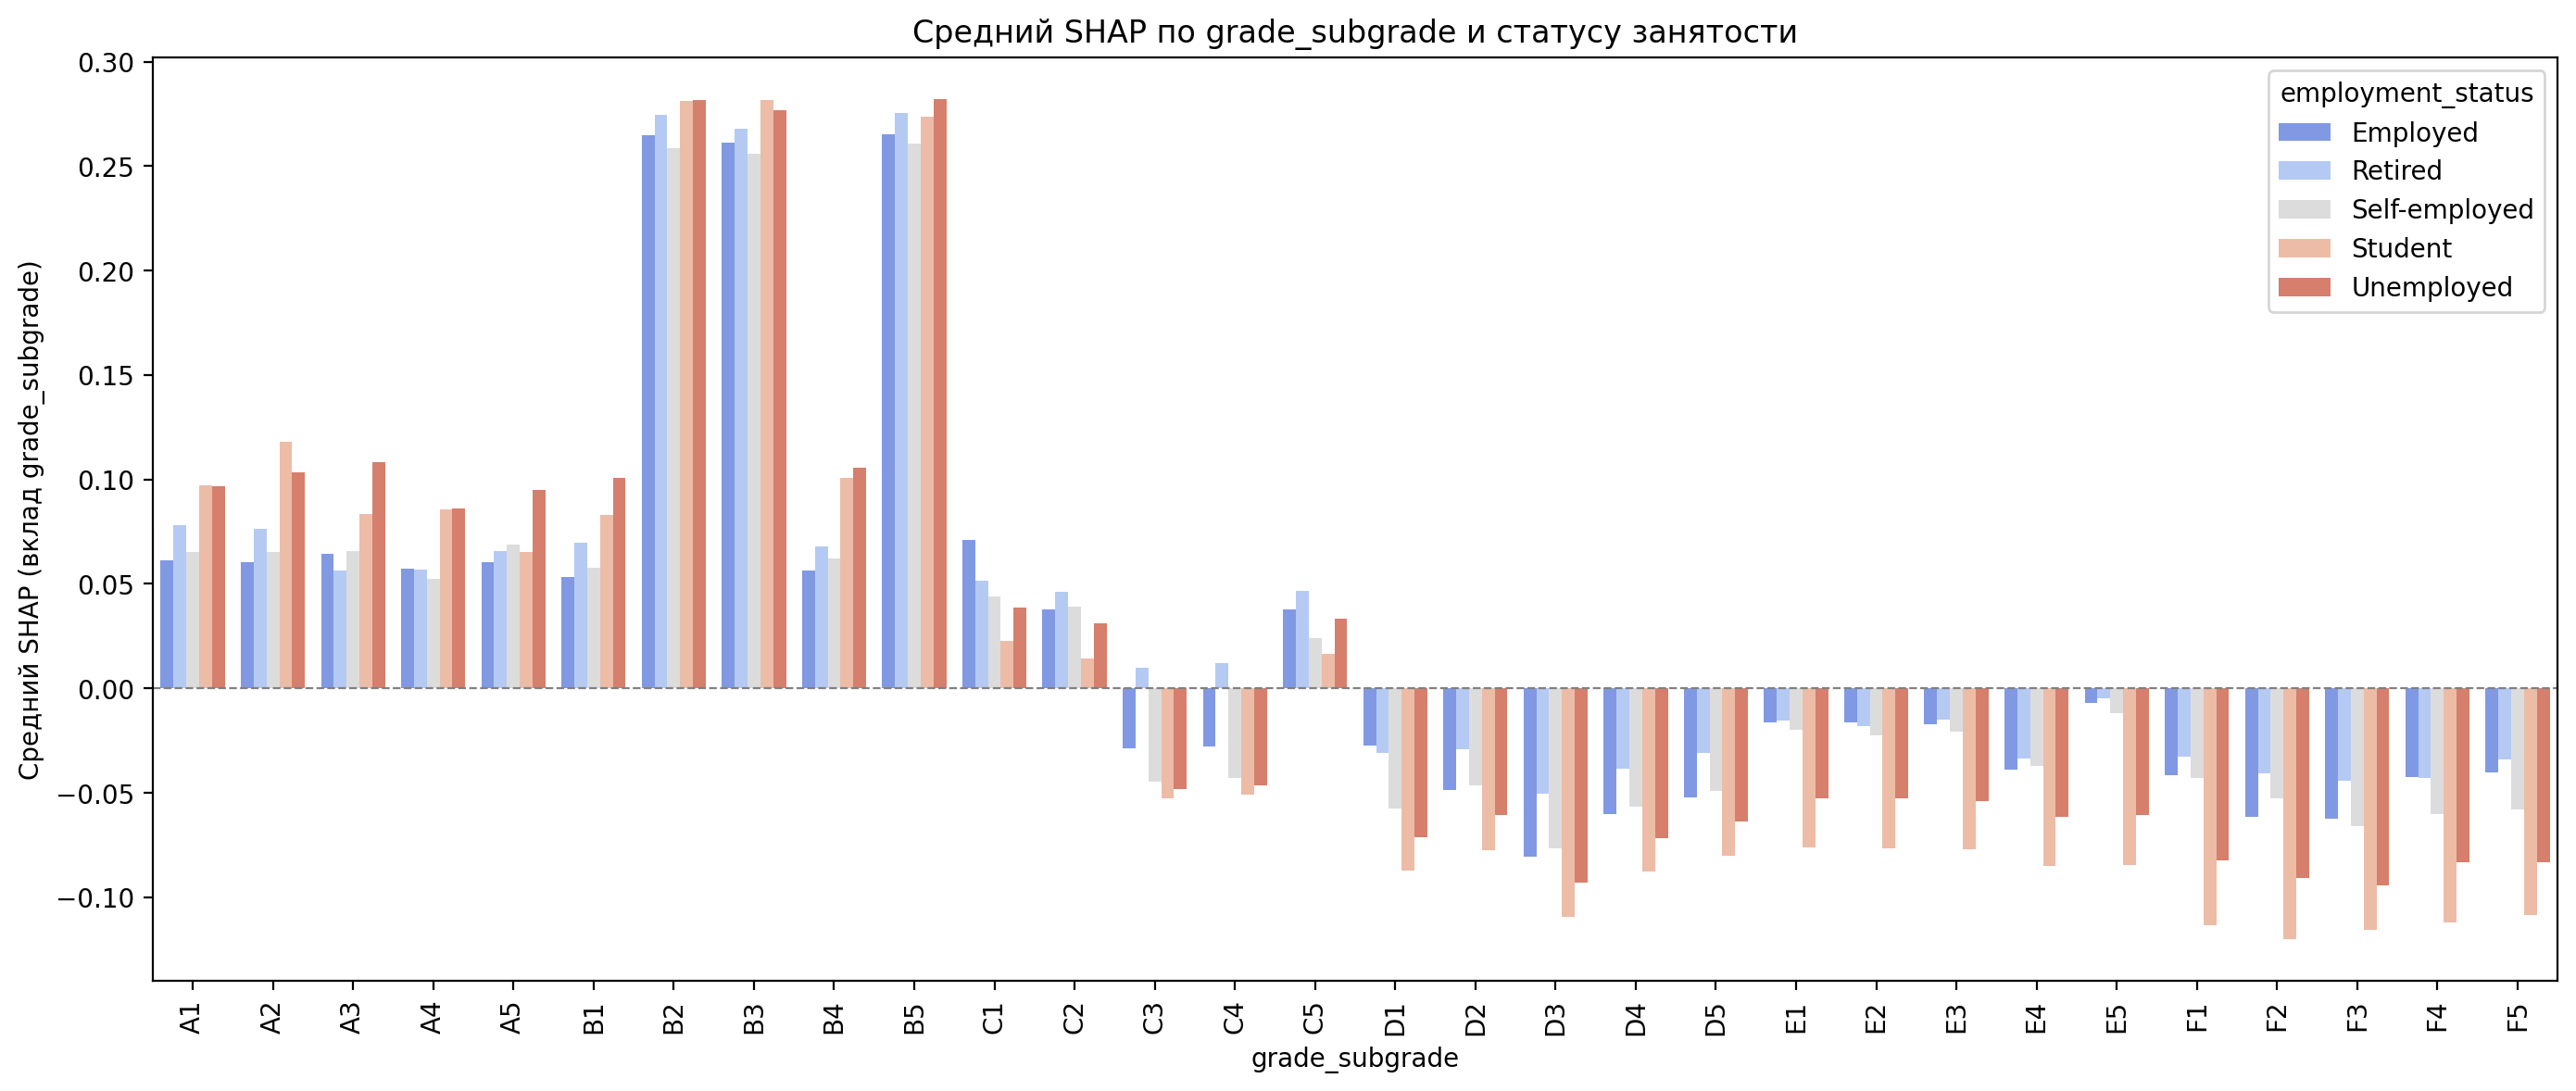

In [136]:
# Если shap_values вернулся списком — возьмём класс 1
sv = shap_values[1] if isinstance(shap_values, list) else shap_values

shap_df = pd.DataFrame(sv, columns=X.columns, index=X.index)


tmp = pd.DataFrame(
    {
        "shap": shap_df["grade_subgrade"],  # SHAP-вклад нужного признака
        "grade_subgrade": X["grade_subgrade"]
        .astype(str)
        .to_numpy(),  # берём как массив, без выравнивания
        "employment_status": X["employment_status"].astype(str).to_numpy(),
    },
    index=X.index,
)

# Средние SHAP по категориям
agg = tmp.groupby(["grade_subgrade", "employment_status"])["shap"].mean().reset_index()

# График
plt.figure(figsize=(14, 6))
sns.barplot(
    data=agg, x="grade_subgrade", y="shap", hue="employment_status", palette="coolwarm"
)
plt.xticks(rotation=90)
plt.axhline(0, color="gray", linestyle="--", linewidth=0.8)
plt.xlabel("grade_subgrade")
plt.ylabel("Средний SHAP (вклад grade_subgrade)")
plt.title("Средний SHAP по grade_subgrade и статусу занятости", fontsize=12)
plt.tight_layout()
plt.show()

Начиная с категории С3- для всех категорий `employment_class` SHAP-значения уходят вниз → вклад в риск дефолта.

📈 То есть: чем хуже рейтинг кредита (grade_subgrade), тем сильнее модель снижает вероятность “loan_paid_back = 1”.

🔵 Employed (внизу шкалы) — точки сдвинуты чуть выше по Y → занятость улучшает прогноз.


🔴 Unemployed / Student — часто встречаются ниже → повышают риск даже при тех же кредитных условиях.


🟣 Self-employed / Retired — где-то между, эффект умеренный.


даже если у двух людей одинаковый кредитный рейтинг (например D3), у работающего SHAP-вклад ближе к нулю, а у безработного — отрицательный.
Модель “понимает”: плохой рейтинг + отсутствие работы = очень высокий риск.

**Вывод:**

согласно работе модели что кредитные классы A–B почти всегда надёжны,
классы С(начиная с С3)–F — рискованные,а статус занятости может смягчать или усиливать риск.
Работающий заёмщик даже с рейтингом D имеет шансы на выплату,
тогда как безработный с тем же рейтингом почти наверняка не выплатит.

Классы E–F (справа)

Все SHAP-значения отрицательные → модель считает эти кредиты потенциально проблемными.

Но различие между статусами всё ещё сохраняется:
Employed и Retired чуть выше (меньший риск),
Unemployed и Student — глубже в минусе (наибольший риск).